<a href="https://colab.research.google.com/github/CodeHunterOfficial/DL_20241S/blob/main/Lecture_8_The_Math_Behind_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow.keras.datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-1-b92e981973c2>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
latent_dim = 128
height = 32
width = 32
channels = 3

In [3]:
def build_generator(latent_dim, height, width, channels):
  inputs = layers.Input(shape=(latent_dim,))
  x = layers.Dense(128 * 16 * 16)(inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Reshape((16, 16, 128))(x)
  x = layers.Conv2D(256, 5, padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(256, 5, padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(256, 5, padding='same')(x)
  x = layers.LeakyReLU()(x)
  output = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
  model = Model(inputs, output)
  print(model.summary())
  return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

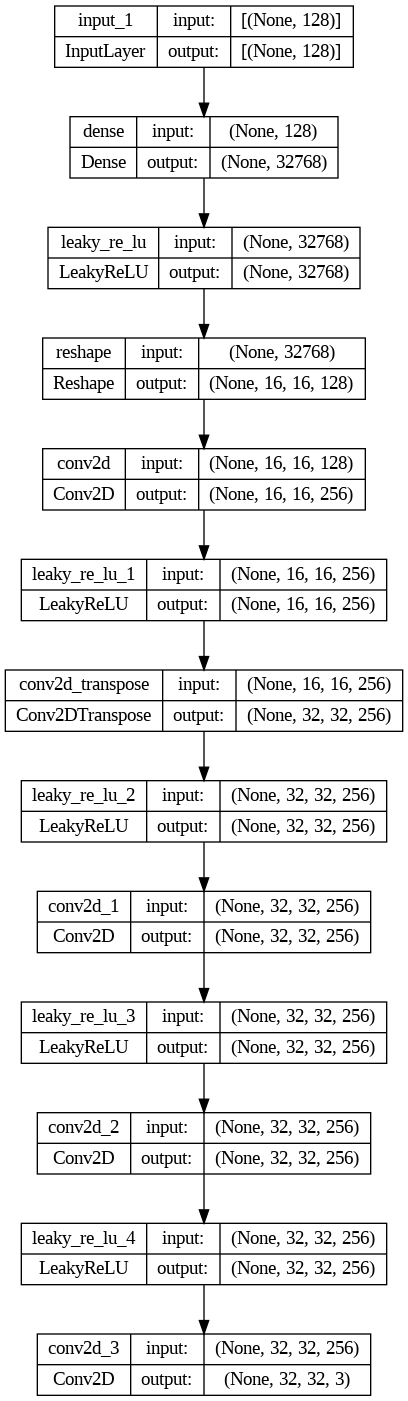

In [4]:
generator = build_generator(latent_dim, height, width, channels)
plot_model(generator, show_shapes=True, show_layer_names=True)

In [10]:
from tensorflow.keras import layers, models, optimizers

def build_discriminator(height, width, channels):
  inputs = layers.Input(shape=(height, width, channels))
  x = layers.Conv2D(128, 3)(inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(128, 4, strides=2)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(128, 4, strides=2)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(128, 4, strides=2)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)
  output = layers.Dense(1, activation='sigmoid')(x)
  model = models.Model(inputs, output)
  optimizer = optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0)
  model.compile(optimizer=optimizer, loss='binary_crossentropy')
  print(model.summary())
  return model


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 6, 6, 128)         0   

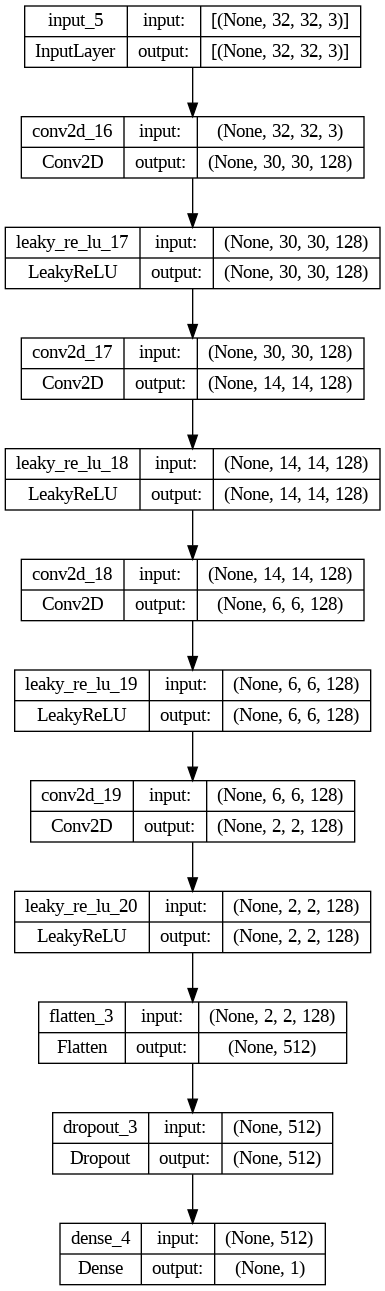

In [11]:
from tensorflow.keras.utils import plot_model

discriminator = build_discriminator(height, width, channels)
plot_model(discriminator, show_shapes=True, show_layer_names=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128)]             0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         9410307   
                                                                 
 model_4 (Functional)        (None, 1)                 790913    
                                                                 
Total params: 10201220 (38.91 MB)
Trainable params: 9410307 (35.90 MB)
Non-trainable params: 790913 (3.02 MB)
_________________________________________________________________
None


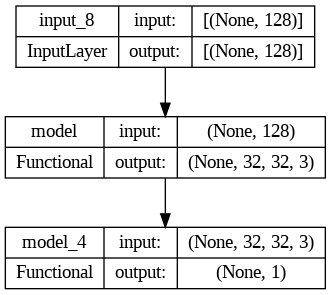

In [14]:
discriminator.trainable = False  # Устанавливаем discriminator.trainable в False

gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
optimizer = optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, rho=0.9)  # Заменяем "decay" на "rho"
gan.compile(optimizer=optimizer, loss='binary_crossentropy')
print(gan.summary())
plot_model(gan, show_shapes=True, show_layer_names=True)

In [15]:
def load_dataset(class_label):
  (X_train, y_train), (X_test, y_test) = tfds.cifar10.load_data()
  X_train = X_train[y_train.flatten() == class_label]
  X_test = X_test[y_test.flatten() == class_label]
  X_train = X_train.astype('float64') / 255.0
  X_test = X_test.astype('float64') / 255.0
  combined_data = np.concatenate([X_train, X_test])
  return combined_data

In [16]:
train_image = load_dataset(8)

170498071/170498071 [==============================] - 6s 0us/step


In [17]:
train_image.shape

(6000, 32, 32, 3)

In [18]:
def train_gan(batch_size, iter_num, latent_dim, data, gan_model, generator_model, discriminator_model):
  start = 0
  d_loss_lst, gan_loss_lst = [], []
  for step in range(iter_num):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator_model.predict(random_latent_vectors)
    real_images = data[start: start + batch_size]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.zeros((batch_size, 1)),
                             np.ones((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator_model.train_on_batch(combined_images, labels)
    d_loss_lst.append(d_loss)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_labels = np.ones((batch_size, 1))
    gan_loss = gan_model.train_on_batch(random_latent_vectors, misleading_labels)
    gan_loss_lst.append(gan_loss)

    if step % 200 == 0:
      print("Iteration {0}/{1}".format(step, iter_num))
      print("[==============================] d-loss: {0:.3f}, gan-loss: {1:.3f}".format(d_loss_lst[-1], gan_loss_lst[-1]))

    start += batch_size
    if start > len(data) - batch_size:
      start = 0

  return gan_model, generator_model, discriminator_model, d_loss_lst, gan_loss_lst

In [ ]:
batch_size = 32
iter_num = 10000

gan, generator, discriminator, d_history, gan_history = train_gan(batch_size, iter_num, latent_dim, train_image, gan, generator, discriminator)

1/1 [==============================] - 5s 5s/step
Iteration 0/10000
[==============================] d-loss: 0.695, gan-loss: 0.675
1/1 [==============================] - 6s 6s/step
Iteration 200/10000
[==============================] d-loss: 0.764, gan-loss: 0.739
1/1 [==============================] - 6s 6s/step
Iteration 400/10000
[==============================] d-loss: 0.731, gan-loss: 0.696
1/1 [==============================] - 5s 5s/step


In [ ]:
def show_generated_image(generator_model, latent_dim, row_num=4):
  num_image = row_num**2
  random_latent_vectors = np.random.normal(size=(num_image, latent_dim))
  generated_images = generator_model.predict(random_latent_vectors)
  plt.figure(figsize=(10,10))
  for i in range(num_image):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.subplot(row_num,row_num,i+1)
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
    plt.imshow(img)
  plt.show()

show_generated_image(generator, latent_dim)

In [ ]:
def plot_learning_curve(d_loss_lst, gan_loss_lst):
  fig = plt.figure()
  plt.plot(d_loss_lst, color='skyblue')
  plt.plot(gan_loss_lst, color='gold')
  plt.title('Model Learning Curve')
  plt.xlabel('Epochs'); plt.ylabel('Cross Entropy Loss')
  plt.show()

plot_learning_curve(d_history, gan_history)